In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_curve, auc, mean_squared_error, 
                             confusion_matrix, accuracy_score)
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier,RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.datasets import make_classification
import imblearn
from imblearn.over_sampling import ADASYN

In [2]:
#Load the dataset
df = pd.read_csv('C:/.../model_df.csv')

In [3]:
#Counting success sub-groups
Counter(df['success'])

Counter({'failure': 40055, 'successful': 10198})

In [4]:
#Label Encoding
label_encoder_success = LabelEncoder()
label_encoder_weekday = LabelEncoder()
label_encoder_PSP = LabelEncoder()
label_encoder_3D_secured = LabelEncoder()
label_encoder_card = LabelEncoder()
label_encoder_unique_transaction = LabelEncoder()

df['success_encoded'] = label_encoder_success.fit_transform(df['success'])
df['weekday_encoded'] = label_encoder_weekday.fit_transform(df['weekday'])
df['PSP_encoded'] = label_encoder_PSP.fit_transform(df['PSP'])
df['3D_secured_encoded'] = label_encoder_3D_secured.fit_transform(df['3D_secured'])
df['card_encoded'] = label_encoder_card.fit_transform(df['card'])
df['unique_transaction_encoded'] = label_encoder_unique_transaction.fit_transform(df['unique_transaction'])

In [5]:
#Significant independent variables according to the Chi-square results 
X = df.loc[:,['weekday_encoded', 'PSP_encoded', '3D_secured_encoded', 'card_encoded', 'unique_transaction_encoded', 'amount']]
y = df['success_encoded']

In [6]:
#ADASYN Sampling
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_resample(X,y)

In [7]:
#Counting success groups after ADASYN
Counter(y_adasyn)

Counter({0: 40055, 1: 38610})

In [8]:
#Splitting dataset as train and test
X_adasyn_train, X_adasyn_test, y_adasyn_train, y_adasyn_test = train_test_split(X_adasyn, y_adasyn, train_size=0.8, random_state=42)

C:\Users\Ezgi\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Ezgi\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Ezgi\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Ezgi\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Ezgi\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Ezgi\anaconda3\lib\site-package

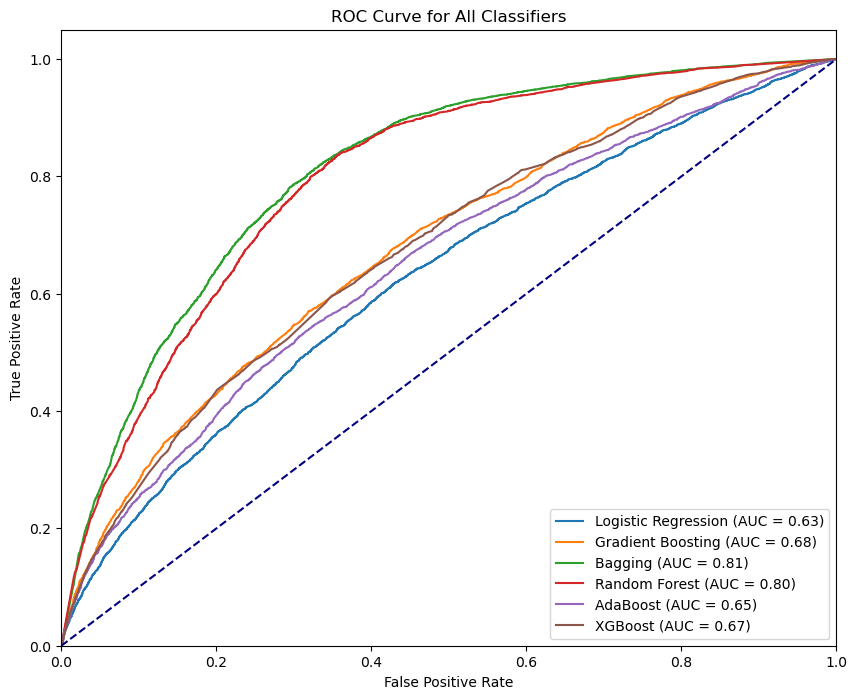

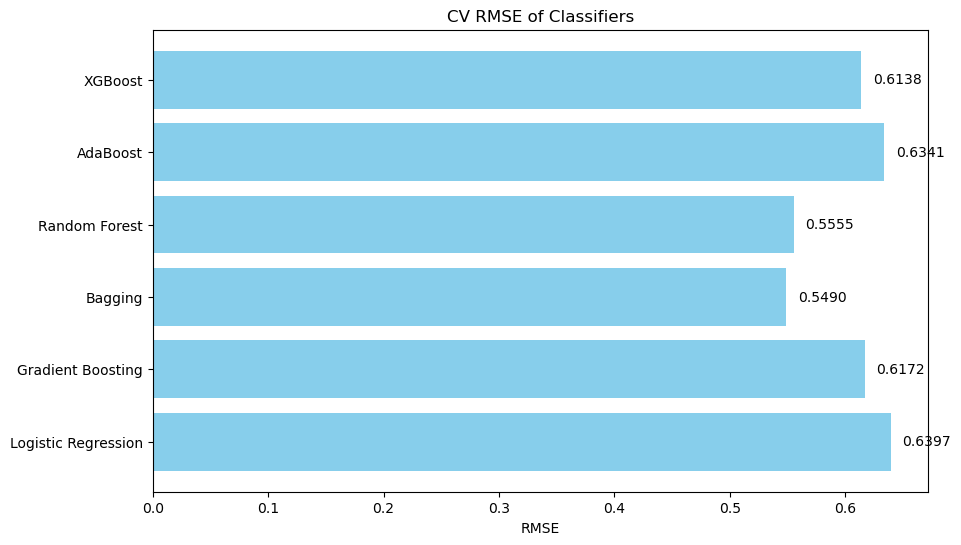

Classifier: Logistic Regression
Train Accuracy: 0.5980
Test Accuracy: 0.5917
CV Precision: 0.5895
CV F1: 0.5679
CV Mean Accuracy: 0.5908
CV RMSE: 0.6397


Classifier: Gradient Boosting
Train Accuracy: 0.6371
Test Accuracy: 0.6242
CV Precision: 0.6200
CV F1: 0.5987
CV Mean Accuracy: 0.6191
CV RMSE: 0.6172


Classifier: Bagging
Train Accuracy: 0.8958
Test Accuracy: 0.7427
CV Precision: 0.6754
CV F1: 0.7077
CV Mean Accuracy: 0.6986
CV RMSE: 0.5490


Classifier: Random Forest
Train Accuracy: 0.8958
Test Accuracy: 0.7359
CV Precision: 0.6684
CV F1: 0.7010
CV Mean Accuracy: 0.6914
CV RMSE: 0.5555


Classifier: AdaBoost
Train Accuracy: 0.6129
Test Accuracy: 0.6110
CV Precision: 0.6019
CV F1: 0.5660
CV Mean Accuracy: 0.5980
CV RMSE: 0.6341


Classifier: XGBoost
Train Accuracy: 0.6329
Test Accuracy: 0.6202
CV Precision: 0.6191
CV F1: 0.6115
CV Mean Accuracy: 0.6233
CV RMSE: 0.6138




In [9]:
# Dictionary to hold results
results = {}

clf = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=7),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=7),
    'Bagging': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=7),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_features=3, random_state=7),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=7),
    'XGBoost': xgb.XGBClassifier(random_state=7, learning_rate=0.01),
}

# Initialize plot for ROC curve
plt.figure(figsize=(10, 8))

for name, clf in clf.items():
    # Fit the classifier
    clf.fit(X_adasyn_train, y_adasyn_train)
    
    # Train and Test accuracy
    train_accuracy = clf.score(X_adasyn_train, y_adasyn_train)
    test_accuracy = clf.score(X_adasyn_test, y_adasyn_test)
    
    # Cross-validated precision, F1, mean accuracy, RMSE
    y_pred_cv = cross_val_predict(clf, X_adasyn, y_adasyn, cv=10)
    cv_precision = precision_score(y_adasyn, y_pred_cv)
    cv_f1 = f1_score(y_adasyn, y_pred_cv)
    cv_mean_accuracy = accuracy_score(y_adasyn, y_pred_cv)
    cv_rmse = np.sqrt(mean_squared_error(y_adasyn, y_pred_cv))
    
    # Store results
    results[name] = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'CV Precision': cv_precision,
        'CV F1': cv_f1,
        'CV Mean Accuracy': cv_mean_accuracy,
        'CV RMSE': cv_rmse
    }
    
    # ROC Curve
    y_probas = clf.predict_proba(X_adasyn_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_adasyn_test, y_probas)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Finalize the ROC plot
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Classifiers')
plt.legend(loc="lower right")
plt.show()

# Plot RMSE values
plt.figure(figsize=(10, 6))
names = list(results.keys())
rmse_values = [results[name]['CV RMSE'] for name in names]
plt.barh(names, rmse_values, color='skyblue')
for i, v in enumerate(rmse_values):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')
plt.xlabel('RMSE')
plt.title('CV RMSE of Classifiers')
plt.show()

# Print out all results
for name, metrics in results.items():
    print(f"Classifier: {name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("\n")
